In [1]:
from datetime import datetime as dt
from keras.applications import inception_v3
from keras import backend as K

Using TensorFlow backend.
/home/crawforc3/anaconda3/lib/python3.6/importlib/_bootstrap.py:205: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)


In [2]:
K.set_learning_phase(0)

In [3]:
model = inception_v3.InceptionV3(weights='imagenet', include_top=False)

In [4]:
layer_contributions = {
    'mixed2': 0.2,
    'mixed3': 3.,
    'mixed4': 2.,
    'mixed5': 1.5,
}

In [5]:
layer_dict = dict([(layer.name, layer) for layer in model.layers])

loss = K.variable(0.)

for layer_name in layer_contributions:
    coeff = layer_contributions[layer_name]
    activation = layer_dict[layer_name].output
    scaling = K.prod(K.cast(K.shape(activation), 'float32'))
    loss += coeff * K.sum(K.square(activation[:, 2: -2, 2: -2, :])) / scaling

In [6]:
dream = model.input

grads = K.gradients(loss, dream)[0]

grads /= K.maximum(K.mean(K.abs(grads)), 1e-7)

outputs = [loss,grads]
fetch_loss_and_grads = K.function([dream], outputs)

In [30]:
import glob
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import scipy
from keras.preprocessing import image

def new_name():
    files = glob.glob("final*.png")
    x = [int(files[i].split("_")[2].strip(".png")) for i in range(len(files))]
    return 'final_dream_' + str((max(x)+1)) + '.png'

def eval_loss_and_grads(x):
    outs = fetch_loss_and_grads([x])
    loss_value = outs[0]
    grad_values = outs[1]
    return loss_value, grad_values


def gradient_ascent(x, iterations, step, max_loss=None):
    for i in range(iterations):
        loss_value, grad_values = eval_loss_and_grads(x)
        if max_loss is not None and loss_value > max_loss:
            break
        #print('\r', '...Loss value at', i, ':', loss_value, end='')
        print('...Loss value at', i, ':', loss_value)
        x += step * grad_values
    return x


def resize_img(img, size):
    img = np.copy(img)
    factors = (1, float(size[0]) / img.shape[1], float(size[1]) / img.shape[2], 1)
    return scipy.ndimage.zoom(img, factors, order=1)


def save_img(img, fname):
    pil_img = deprocess_image(np.copy(img))
    scipy.misc.imsave(fname, pil_img)
    #scipy.imageio.imwrite

    
def preprocess_image(image_path):
    img = image.load_img(image_path)
    img = image.img_to_array(img)
    img = np.expand_dims(img, axis=0)
    img = inception_v3.preprocess_input(img)
    return img


def deprocess_image(x):
    if K.image_data_format() == 'channels_first':
        x = x.reshape((3, x.shape[2], x.shape[3]))
        x = x.transpose((1, 2, 0))
    else:
        x = x.reshape((x.shape[1], x.shape[2], 3))
    x /= 2.
    x += 0.5
    x *= 255.
    x = np.clip(x, 0, 255).astype('uint8')
    return x

final_dream_85.png
Octave # 0  - Processing image shape (762, 571)
...Loss value at 0 : 1.58685
...Loss value at 1 : 2.15132
...Loss value at 2 : 2.89489
...Loss value at 3 : 3.73325
...Loss value at 4 : 4.59399
...Loss value at 5 : 5.44346
...Loss value at 6 : 6.27438
...Loss value at 7 : 7.07229
...Loss value at 8 : 7.86178
...Loss value at 9 : 8.59948
...Loss value at 10 : 9.32144
...Loss value at 11 : 10.0383
...Loss value at 12 : 10.7073
...Loss value at 13 : 11.3671
...Loss value at 14 : 11.98
...Loss value at 15 : 12.6135
...Loss value at 16 : 13.2099
...Loss value at 17 : 13.763
...Loss value at 18 : 14.3227
...Loss value at 19 : 14.8471


/home/crawforc3/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:39: DeprecationWarning: `imsave` is deprecated!
`imsave` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imwrite`` instead.
/home/crawforc3/anaconda3/lib/python3.6/site-packages/scipy/ndimage/interpolation.py:616: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)


Octave # 1  - Processing image shape (763, 572)
...Loss value at 0 : 8.99046
...Loss value at 1 : 11.265
...Loss value at 2 : 12.2807
...Loss value at 3 : 13.183
...Loss value at 4 : 13.9638
...Loss value at 5 : 14.7063
...Loss value at 6 : 15.3788
...Loss value at 7 : 15.9602
...Loss value at 8 : 16.5441
...Loss value at 9 : 17.0922
...Loss value at 10 : 17.6413
...Loss value at 11 : 18.1426
...Loss value at 12 : 18.641
...Loss value at 13 : 19.1046
...Loss value at 14 : 19.5613
...Loss value at 15 : 20.0046
...Loss value at 16 : 20.458
...Loss value at 17 : 20.8797
...Loss value at 18 : 21.3005
...Loss value at 19 : 21.7049
Octave # 2  - Processing image shape (763, 573)
...Loss value at 0 : 15.0286
...Loss value at 1 : 17.8084
...Loss value at 2 : 18.8479
...Loss value at 3 : 19.6418
...Loss value at 4 : 20.3912
...Loss value at 5 : 21.0242
...Loss value at 6 : 21.5957
...Loss value at 7 : 22.1412
...Loss value at 8 : 22.6425
...Loss value at 9 : 23.1261
...Loss value at 10 : 23.572

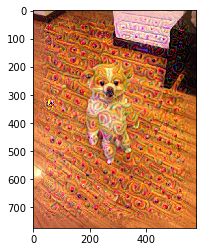

In [31]:
start = dt.now()
new_file = new_name()
print(new_file)

# Hyperparamters to play with
step = 0.01
num_octave = 15
octave_scale = 1.001
iterations = 20
max_loss = 50.

base_image_path = 'dog.jpg'

img = preprocess_image(base_image_path)

original_shape = img.shape[1:3]

successive_shapes = [original_shape]

for i in range(1, num_octave):
    shape = tuple([int(dim / (octave_scale ** i)) for dim in original_shape])
    successive_shapes.append(shape)

successive_shapes = successive_shapes[::-1]

original_img = np.copy(img)

shrunk_original_img = resize_img(img, successive_shapes[0])

for i,shape in enumerate(successive_shapes):
    print('Octave #', i, ' - Processing image shape', shape)
    img = resize_img(img,shape)
    img = gradient_ascent(img, iterations=iterations, step=step, max_loss=max_loss)
    upscaled_shrunk_original_img = resize_img(shrunk_original_img, shape)
    same_size_original = resize_img(original_img, shape)
    lost_detail = same_size_original - upscaled_shrunk_original_img
    
    img += lost_detail
    shrunk_original_img = resize_img(original_img, shape)
    save_img(img, fname='dream_at_scale' + str(shape) + '.png')

save_img(img, fname=new_file)

stop = dt.now()
print("\n", (stop - start).seconds, "seconds")
print("Done.")

image = mpimg.imread(new_file)
plt.imshow(image)
plt.show()